In [1]:
import sys
import numpy as np
import torch
sys.path.append("../")  
import src.RBM as rbm

In [ ]:
visible_dim = 443136 
hidden_dim = 1000
sigma = 10
RBM =  rbm.GaussianBinaryRBM(visible_dim, hidden_dim, sigma)

In [3]:
print(RBM)

GaussianBinaryRBM()


In [4]:
batch_size = 10
Batch_data = torch.randn(batch_size, visible_dim)
Batch_data = torch.tanh(Batch_data)
print(Batch_data)

tensor([[-0.8911,  0.9224,  0.6473,  ..., -0.1483,  0.3817,  0.5457],
        [ 0.5676, -0.5144,  0.7028,  ..., -0.6673, -0.2403, -0.7806],
        [ 0.7422, -0.6366, -0.3003,  ..., -0.9283, -0.1879, -0.7913],
        ...,
        [-0.4237, -0.0208,  0.8219,  ...,  0.7231, -0.4927,  0.7166],
        [-0.5657,  0.8528,  0.4696,  ..., -0.1294,  0.7307, -0.9172],
        [-0.1491, -0.8817,  0.1900,  ..., -0.8604, -0.9480, -0.9676]])


In [5]:
import matplotlib.pyplot as plt

def plot_erreur(epoch, error):
    """" Tracer la courbe d'évolution de l'erreur """
    
    plt.plot(range(epoch), error, label="Erreur de reconstruction")
    plt.xlabel("Époque")
    plt.ylabel("Erreur")
    plt.title("Évolution de l'erreur de reconstruction")
    plt.legend()
    plt.show() 

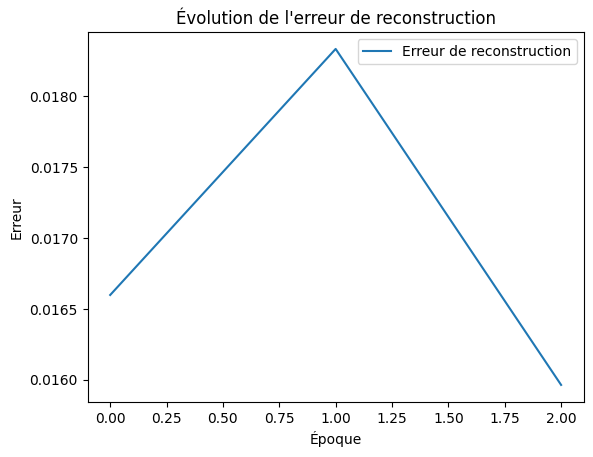

In [6]:
epoch = 3
error_score = []
Batch_error = torch.zeros(batch_size, visible_dim)

for _ in range(epoch):
    # Applique le contraste de divergence sur le lot
    RBM.contrastive_divergence(Batch_data)
    
    # Effectue la propagation avant pour obtenir les prédictions
    Batch_pred = RBM.forward(Batch_data)

    
    # Calcul de l'erreur
    Batch_error = Batch_data - Batch_pred
    error = 0  
    
    # Imprimer Batch_error pour voir l'écart entre les données et les prédictions
    #print(f"Batch_error: {Batch_error}")
    
    for i in range(len(Batch_error)):
        error = error + (1/visible_dim)*torch.sqrt(((Batch_error[i, :]) ** 2).sum()).item()

    error_score.append(error)  # Erreur quadratique
plot_erreur(epoch, error_score)



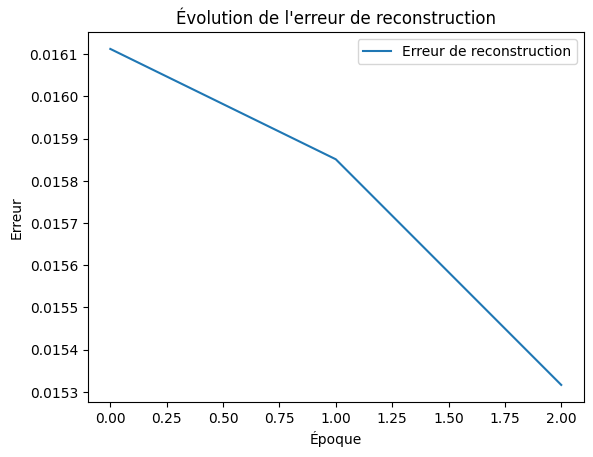

In [7]:
epoch = 3
error_score = []
Batch_error = torch.zeros(batch_size, visible_dim)
persistent_v = None
for _ in range(epoch):
    # Applique le contraste de divergence sur le lot
    persistent_v = RBM.persistent_contrastive_divergence(Batch_data, persistent_v)
    
    # Effectue la propagation avant pour obtenir les prédictions
    Batch_pred = RBM.forward(Batch_data)

    
    # Calcul de l'erreur
    Batch_error = Batch_data - Batch_pred
    error = 0  
    
    for i in range(len(Batch_error)):
        error = error + (1/visible_dim)*torch.sqrt(((Batch_error[i, :]) ** 2).sum()).item()

    error_score.append(error)  # Erreur quadratique

plot_erreur(epoch, error_score)   

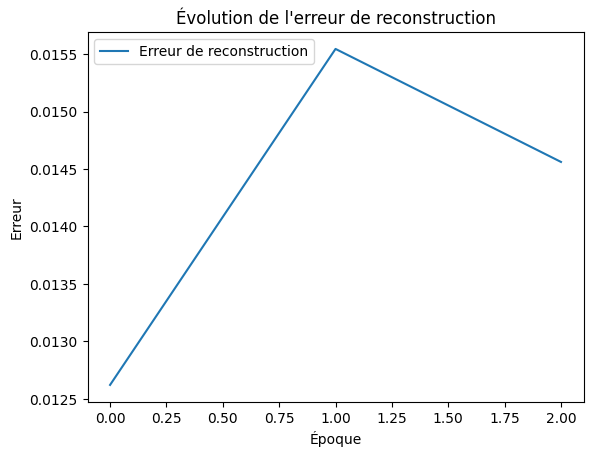

In [8]:
epoch = 3
error_score = []
Batch_error = torch.zeros(batch_size, visible_dim)
persistent_v = None
for _ in range(epoch):
    # Applique le contraste de divergence sur le lot
    persistent_v = RBM.fast_persistent_contrastive_divergence(Batch_data, persistent_v)
    
    # Effectue la propagation avant pour obtenir les prédictions
    Batch_pred = RBM.forward(Batch_data)

    
    # Calcul de l'erreur
    Batch_error = Batch_data - Batch_pred
    error = 0  
    
    for i in range(len(Batch_error)):
        error = error + (1/visible_dim)*torch.sqrt(((Batch_error[i, :]) ** 2).sum()).item()

    error_score.append(error)  # Erreur quadratique

plot_erreur(epoch, error_score)

In [26]:
# Sauvegarder le modèle 

torch.save(RBM.state_dict(), '../models_saved/RBM_contrast_div.pth')